SYNTHETIC A/B TEST DATA GENERATOR

Experiment Parameters:
Control group size: 1,000 users
Test group size: 1,000 users
Expected control retention: 30.0%
Expected test retention: 35.0%
Expected absolute lift: 5.0%
Expected relative lift: 16.7%

Generating synthetic A/B test data...
Generating control group: 1000 users with 30.0% retention rate
Generating test group: 1000 users with 35.0% retention rate
Generated synthetic dataset with 2000 total users

Generated Dataset Info:
Total records: 2,000
Columns: ['user_id', 'group', 'has_referral_feature', 'retained_30_days', 'signup_date', 'user_segment', 'acquisition_channel']

Sample of generated data:
        user_id    group  has_referral_feature  retained_30_days signup_date  \
0     test_0860     test                  True                 0  2024-03-19   
1  control_0353  control                 False                 0  2024-02-14   
2     test_0333     test                  True                 0  2024-01-11   
3  control_0905  control

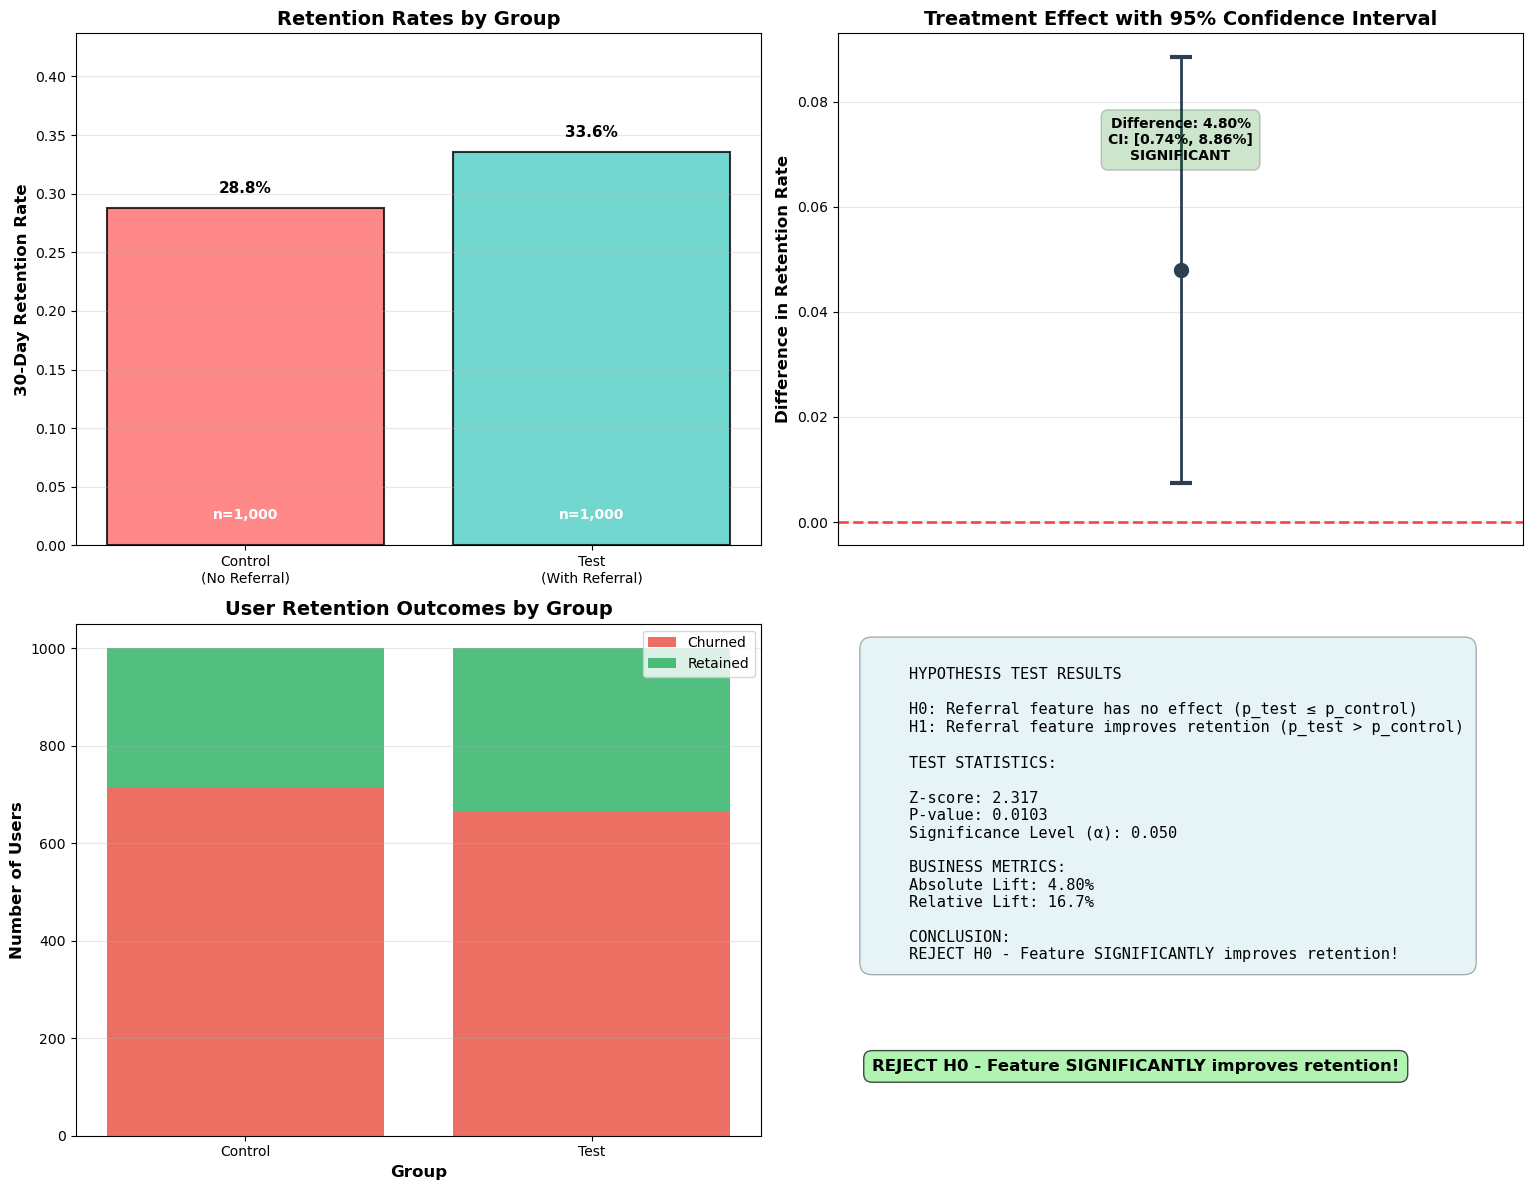


SEGMENTED ANALYSIS

Analysis by User Segment:
                      Total_Users  Retained_Users  Retention_Rate
user_segment group                                               
existing     control          317              95           0.300
             test             293              91           0.311
new          control          683             193           0.283
             test             707             245           0.347

Analysis by Acquisition Channel:
                             Total_Users  Retained_Users  Retention_Rate
acquisition_channel group                                               
organic             control          401             117           0.292
                    test             412             136           0.330
paid                control          395             118           0.299
                    test             402             128           0.318
social              control          204              53           0.260
            

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

def generate_synthetic_ab_test_data(n_control, n_test, p_control, p_test, random_state=42):
    """
    Generate synthetic A/B test data for referral feature experiment
    
    Parameters:
    -----------
    n_control : int
        Number of users in control group
    n_test : int  
        Number of users in test group
    p_control : float
        True retention rate for control group (0-1)
    p_test : float
        True retention rate for test group (0-1)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    pd.DataFrame
        Synthetic experiment data
    """
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Generate control group data
    print(f"Generating control group: {n_control} users with {p_control:.1%} retention rate")
    control_retained = np.random.binomial(1, p_control, n_control)
    
    control_data = []
    for i in range(n_control):
        control_data.append({
            'user_id': f'control_{i:04d}',
            'group': 'control',
            'has_referral_feature': False,
            'retained_30_days': control_retained[i],
            'signup_date': pd.Timestamp('2024-01-01') + pd.Timedelta(days=np.random.randint(0, 90)),
            'user_segment': np.random.choice(['new', 'existing'], p=[0.7, 0.3]),
            'acquisition_channel': np.random.choice(['organic', 'paid', 'social'], p=[0.4, 0.4, 0.2])
        })
    
    # Generate test group data  
    print(f"Generating test group: {n_test} users with {p_test:.1%} retention rate")
    test_retained = np.random.binomial(1, p_test, n_test)
    
    test_data = []
    for i in range(n_test):
        test_data.append({
            'user_id': f'test_{i:04d}',
            'group': 'test',
            'has_referral_feature': True,
            'retained_30_days': test_retained[i],
            'signup_date': pd.Timestamp('2024-01-01') + pd.Timedelta(days=np.random.randint(0, 90)),
            'user_segment': np.random.choice(['new', 'existing'], p=[0.7, 0.3]),
            'acquisition_channel': np.random.choice(['organic', 'paid', 'social'], p=[0.4, 0.4, 0.2])
        })
    
    # Combine data
    all_data = control_data + test_data
    df = pd.DataFrame(all_data)
    
    # Shuffle the data
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    print(f"Generated synthetic dataset with {len(df)} total users")
    return df

def analyze_ab_test_results(df, alpha=0.05):
    """
    Perform statistical analysis of A/B test results
    
    Parameters:
    -----------
    df : pd.DataFrame
        Experiment data with columns: group, retained_30_days
    alpha : float
        Significance level for hypothesis testing
        
    Returns:
    --------
    dict
        Statistical test results
    """
    
    # Calculate basic metrics
    control_data = df[df['group'] == 'control']
    test_data = df[df['group'] == 'test']
    
    n_control = len(control_data)
    n_test = len(test_data)
    
    conversions_control = control_data['retained_30_days'].sum()
    conversions_test = test_data['retained_30_days'].sum()
    
    p_control = conversions_control / n_control
    p_test = conversions_test / n_test
    
    # Calculate pooled proportion for standard error
    p_pooled = (conversions_control + conversions_test) / (n_control + n_test)
    
    # Standard error for difference in proportions
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_test))
    
    # Test statistic (z-score)
    z_score = (p_test - p_control) / se
    
    # P-value for one-tailed test (H1: p_test > p_control)
    p_value = 1 - norm.cdf(z_score)
    
    # Confidence interval for the difference
    diff = p_test - p_control
    se_diff = np.sqrt((p_control * (1 - p_control) / n_control) + 
                      (p_test * (1 - p_test) / n_test))
    
    margin_of_error = norm.ppf(1 - alpha/2) * se_diff
    ci_lower = diff - margin_of_error
    ci_upper = diff + margin_of_error
    
    # Effect size (relative lift)
    relative_lift = (p_test - p_control) / p_control if p_control > 0 else 0
    
    # Statistical significance
    is_significant = p_value < alpha
    
    results = {
        'sample_size_control': n_control,
        'sample_size_test': n_test,
        'conversions_control': conversions_control,
        'conversions_test': conversions_test,
        'control_retention_rate': p_control,
        'test_retention_rate': p_test,
        'absolute_difference': diff,
        'relative_lift': relative_lift,
        'z_score': z_score,
        'p_value': p_value,
        'is_significant': is_significant,
        'confidence_interval': (ci_lower, ci_upper),
        'alpha': alpha
    }
    
    return results

def plot_ab_test_results(df, results):
    """
    Create comprehensive visualizations for A/B test results
    """
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Retention rates comparison
    groups = ['Control\n(No Referral)', 'Test\n(With Referral)']
    retention_rates = [results['control_retention_rate'], results['test_retention_rate']]
    colors = ['#ff6b6b', '#4ecdc4']
    
    bars = ax1.bar(groups, retention_rates, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.set_ylabel('30-Day Retention Rate', fontsize=12, fontweight='bold')
    ax1.set_title('Retention Rates by Group', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, max(retention_rates) * 1.3)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, retention_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                f'{rate:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add sample sizes
    sample_sizes = [results['sample_size_control'], results['sample_size_test']]
    for bar, size in zip(bars, sample_sizes):
        ax1.text(bar.get_x() + bar.get_width()/2, 0.02,
                f'n={size:,}', ha='center', va='bottom', fontsize=10, color='white', fontweight='bold')
    
    # 2. Confidence interval plot
    diff = results['absolute_difference']
    ci_lower, ci_upper = results['confidence_interval']
    
    ax2.errorbar(0, diff, yerr=[[diff - ci_lower], [ci_upper - diff]], 
                fmt='o', markersize=10, capsize=8, capthick=3, color='#2c3e50', linewidth=2)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax2.set_xlim(-0.8, 0.8)
    ax2.set_ylabel('Difference in Retention Rate', fontsize=12, fontweight='bold')
    ax2.set_title(f'Treatment Effect with {int((1-results["alpha"])*100)}% Confidence Interval', 
                  fontsize=14, fontweight='bold')
    ax2.set_xticks([])
    ax2.grid(True, alpha=0.3)
    
    # Add annotations
    significance_text = "SIGNIFICANT" if results['is_significant'] else "NOT SIGNIFICANT"
    color = 'green' if results['is_significant'] else 'red'
    
    ax2.text(0, diff + (ci_upper - diff) * 0.5, 
            f'Difference: {diff:.2%}\nCI: [{ci_lower:.2%}, {ci_upper:.2%}]\n{significance_text}',
            ha='center', va='bottom', 
            bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.2),
            fontsize=10, fontweight='bold')
    
    # 3. Distribution of outcomes by group
    control_outcomes = df[df['group'] == 'control']['retained_30_days']
    test_outcomes = df[df['group'] == 'test']['retained_30_days']
    
    x_pos = np.arange(2)
    retention_counts = [
        [len(control_outcomes) - control_outcomes.sum(), control_outcomes.sum()],
        [len(test_outcomes) - test_outcomes.sum(), test_outcomes.sum()]
    ]
    
    churned = [retention_counts[0][0], retention_counts[1][0]]
    retained = [retention_counts[0][1], retention_counts[1][1]]
    
    ax3.bar(x_pos, churned, label='Churned', color='#e74c3c', alpha=0.8)
    ax3.bar(x_pos, retained, bottom=churned, label='Retained', color='#27ae60', alpha=0.8)
    
    ax3.set_xlabel('Group', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
    ax3.set_title('User Retention Outcomes by Group', fontsize=14, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(['Control', 'Test'])
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Statistical summary
    ax4.axis('off')
    
    # Hypothesis text
    hypothesis_text = """
    HYPOTHESIS TEST RESULTS
    
    H0: Referral feature has no effect (p_test ≤ p_control)
    H1: Referral feature improves retention (p_test > p_control)
    
    TEST STATISTICS:
    """
    
    stats_text = f"""
    Z-score: {results['z_score']:.3f}
    P-value: {results['p_value']:.4f}
    Significance Level (α): {results['alpha']:.3f}
    
    BUSINESS METRICS:
    Absolute Lift: {results['absolute_difference']:.2%}
    Relative Lift: {results['relative_lift']:.1%}
    
    CONCLUSION:
    """
    
    if results['is_significant']:
        conclusion = "REJECT H0 - Feature SIGNIFICANTLY improves retention!"
        conclusion_color = 'lightgreen'
    else:
        conclusion = "FAIL TO REJECT H0 - No significant improvement detected"
        conclusion_color = 'lightcoral'
    
    # Combine all text
    full_text = hypothesis_text + stats_text + conclusion
    
    ax4.text(0.05, 0.95, full_text, transform=ax4.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.8", facecolor="lightblue", alpha=0.3))
    
    ax4.text(0.05, 0.15, conclusion, transform=ax4.transAxes, fontsize=12,
            verticalalignment='top', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor=conclusion_color, alpha=0.7))
    
    plt.tight_layout()
    plt.show()

def segment_analysis(df):
    """
    Perform segmented analysis of A/B test results
    """
    print("\n" + "="*60)
    print("SEGMENTED ANALYSIS")
    print("="*60)
    
    # Analysis by user segment
    print("\nAnalysis by User Segment:")
    segment_results = df.groupby(['user_segment', 'group'])['retained_30_days'].agg(['count', 'sum', 'mean']).round(3)
    segment_results.columns = ['Total_Users', 'Retained_Users', 'Retention_Rate']
    print(segment_results)
    
    # Analysis by acquisition channel
    print("\nAnalysis by Acquisition Channel:")
    channel_results = df.groupby(['acquisition_channel', 'group'])['retained_30_days'].agg(['count', 'sum', 'mean']).round(3)
    channel_results.columns = ['Total_Users', 'Retained_Users', 'Retention_Rate']
    print(channel_results)

# Main execution
def main():
    print("SYNTHETIC A/B TEST DATA GENERATOR")
    print("="*50)
    
    # Parameters for data generation
    n_control = 1000  # Users in control group
    n_test = 1000     # Users in test group  
    p_control = 0.30  # 30% retention rate in control
    p_test = 0.35     # 35% retention rate in test (5% absolute lift)
    
    print(f"\nExperiment Parameters:")
    print(f"Control group size: {n_control:,} users")
    print(f"Test group size: {n_test:,} users")
    print(f"Expected control retention: {p_control:.1%}")
    print(f"Expected test retention: {p_test:.1%}")
    print(f"Expected absolute lift: {p_test - p_control:.1%}")
    print(f"Expected relative lift: {(p_test - p_control) / p_control:.1%}")
    
    # Generate synthetic data
    print(f"\nGenerating synthetic A/B test data...")
    experiment_df = generate_synthetic_ab_test_data(
        n_control=n_control,
        n_test=n_test, 
        p_control=p_control,
        p_test=p_test,
        random_state=42
    )
    
    # Display dataset info
    print(f"\nGenerated Dataset Info:")
    print(f"Total records: {len(experiment_df):,}")
    print(f"Columns: {list(experiment_df.columns)}")
    
    print(f"\nSample of generated data:")
    print(experiment_df.head(10))
    
    print(f"\nBasic statistics:")
    basic_stats = experiment_df.groupby('group')['retained_30_days'].agg(['count', 'sum', 'mean']).round(3)
    basic_stats.columns = ['Total_Users', 'Retained_Users', 'Retention_Rate'] 
    print(basic_stats)
    
    # Perform statistical analysis
    print(f"\nPerforming statistical analysis...")
    results = analyze_ab_test_results(experiment_df, alpha=0.05)
    
    print(f"\nSTATISTICAL TEST RESULTS:")
    print(f"Control retention rate: {results['control_retention_rate']:.1%}")
    print(f"Test retention rate: {results['test_retention_rate']:.1%}")
    print(f"Absolute difference: {results['absolute_difference']:.2%}")
    print(f"Relative lift: {results['relative_lift']:.1%}")
    print(f"Z-score: {results['z_score']:.3f}")
    print(f"P-value: {results['p_value']:.4f}")
    print(f"95% Confidence interval: [{results['confidence_interval'][0]:.2%}, {results['confidence_interval'][1]:.2%}]")
    
    if results['is_significant']:
        print(f"\nRESULT: STATISTICALLY SIGNIFICANT")
        print(f"We can reject H0 with 95% confidence.")
        print(f"The referral feature significantly improves 30-day retention!")
    else:
        print(f"\nRESULT: NOT STATISTICALLY SIGNIFICANT") 
        print(f"We fail to reject H0.")
        print(f"No significant evidence that referral feature improves retention.")
    
    # Create visualizations
    print(f"\nCreating visualizations...")
    plot_ab_test_results(experiment_df, results)
    
    # Segmented analysis
    segment_analysis(experiment_df)
    
    # Business recommendations
    print(f"\nBUSINESS RECOMMENDATIONS:")
    if results['is_significant']:
        monthly_users = 50000  # Example monthly new users
        additional_retained = monthly_users * results['absolute_difference']
        print(f"RECOMMEND: Roll out the referral feature to all users")
        print(f"Expected impact: With {monthly_users:,} monthly users, expect ~{additional_retained:.0f} additional retained users per month")
        print(f"Next steps: Monitor long-term retention (90-day, 6-month) and user engagement metrics")
        print(f"Consider: Segmented rollout to validate results across different user types")
    else:
        print(f"RECOMMEND: Do NOT roll out referral feature in current form")
        print(f"Next steps: Investigate feature improvements or test with different user segments")
        print(f"Consider: Longer test duration or larger sample size to detect smaller effects")
        print(f"Re-evaluate: Success metrics and minimum practical effect size")
    
    return experiment_df, results

# Run the analysis
if __name__ == "__main__":
    df, test_results = main()